In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
import re

# Step 1: Load your CSV
# file_path = "analysisData_061325.csv"  # adjust path if needed
file_path = '/Users/jcoleman/Documents/--LARGE DATA--/#Pizzi/TBI-sham leak analysis/scripts/matlab-copy/August 2024/analysisData_061325.csv'
df = pd.read_csv(file_path)




In [2]:
# 2. Collect logical columns using substrings
substrings_cap = ['midLogical', 'preLogical', 'pstLogical']
logical_columns = [col for col in df.columns if any(sub in col for sub in substrings_cap)]

# 3. Reshape logicals to long format
logical_long = []
for col in logical_columns:
    match = re.match(r'(.*)_(\d+)', col)
    if match:
        logic_type, roi_idx = match.groups()
        temp_df = pd.DataFrame({
            'filename': df['filename'],
            'ROI': int(roi_idx),
            'logic_type': logic_type,
            'value': df[col]
        })
        logical_long.append(temp_df)

logic_combined = pd.concat(logical_long)
logic_wide = logic_combined.pivot_table(index=['filename', 'ROI'],
                                        columns='logic_type',
                                        values='value',
                                        aggfunc='first').reset_index()

# 4. Convert logic columns to numeric
for col in logic_wide.columns:
    if col not in ['filename', 'ROI']:
        logic_wide[col] = pd.to_numeric(logic_wide[col], errors='coerce').fillna(0)

# 5. Define vessel types
logic_wide['VesselType'] = np.select(
    [
        logic_wide.get('midLogical', 0) == 1,
        (logic_wide.get('preLogical', 0) == 1) | (logic_wide.get('pstLogical', 0) == 1)
    ],
    ['farBifCap', 'nearBifCap'],
    default='unknown'
)


In [9]:
# Drop any existing 'group' column to avoid merge conflict
if 'group' in df.columns:
    final_df = df.drop(columns='group')

# Make a clean group lookup table from the original df
group_lookup = df[['filename', 'group']].drop_duplicates().copy()

# Convert 'A' and 'B' to meaningful names
group_lookup['group'] = group_lookup['group'].map({'A': 'rmTBI', 'B': 'Sham'})

# Merge into final_df on filename
final_df = final_df.merge(group_lookup, on='filename', how='left')


In [10]:
print(final_df['group'].value_counts())


group
rmTBI    6
Sham     4
Name: count, dtype: int64


In [11]:
# 6. Melt FeFv data
feFv_cols = [f'meanFeFv_{i}' for i in range(1, 41)]
feFv_long = pd.melt(df[['filename'] + feFv_cols], id_vars='filename',
                    var_name='ROI', value_name='meanFeFv')
feFv_long['ROI'] = feFv_long['ROI'].str.extract(r'(\d+)').astype(int)

# 7. Merge with logic data
final_df = pd.merge(logic_wide, feFv_long, on=['filename', 'ROI'], how='inner')

# 8. Assign group from filename
# final_df['Group'] = final_df['filename'].apply(lambda x: 'rmTBI' if 'A' in x else 'Sham')
# Drop any existing 'group' column to avoid merge conflict
if 'group' in final_df.columns:
    final_df = final_df.drop(columns='group')

# Make a clean group lookup table from the original df
group_lookup = df[['filename', 'group']].drop_duplicates().copy()

# Convert 'A' and 'B' to meaningful names
group_lookup['group'] = group_lookup['group'].map({'A': 'rmTBI', 'B': 'Sham'})

# Merge into final_df on filename
final_df = final_df.merge(group_lookup, on='filename', how='left')
print(final_df['group'].value_counts())

# 9. Filter and Z-score
final_df = final_df[(final_df['VesselType'] != 'unknown') & final_df['meanFeFv'].notna()]
final_df['Z_meanFeFv'] = zscore(final_df['meanFeFv'])

group
rmTBI    134
Sham      79
Name: count, dtype: int64


In [12]:
print(final_df.shape)
# print(cap_df[['VesselType', 'Group', 'Z_meanFeFv']].dropna())

(190, 9)


In [14]:
print(logic_wide.shape)
print(feFv_long.shape)

# Check overlap in ROI and filename values
print(set(logic_wide['filename']) & set(feFv_long['filename']))
print(set(logic_wide['ROI']) & set(feFv_long['ROI']))


(213, 6)
(400, 3)
{'ZT10_16X6x_gg_800nm_m5_roi2_00003_ROIs_classA', 'ZT10_16X6x_gg_800nm_m16_roi1_00001_ROIs_classA', 'ZT10_16X6x_gg_800nm_m15_roi1_00001_ROIs_classA', 'ZT10_16X6x_gg_800nm_m9_roi1_00002_ROIs_classA', 'ZT10_16X6x_gg_800nm_m10_roi1_00001_ROIs_classA', 'ZT10_16X6x_gg_800nm_m12_roi1_00001_ROIs_classA', 'ZT10_16X6x_gg_800nm_m11_roi1_00001_ROIs_classA', 'ZT10_16X6x_gg_800nm_m7_roi1_00001_ROIs_classA', 'ZT10_16X6x_gg_800nm_m13_roi1_00002_ROIs_classA', 'ZT10_16X6x_gg_800nm_m6_roi1_00001_ROIs_classA'}
{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40}


In [15]:
merged = pd.merge(logic_wide, feFv_long, on=['filename', 'ROI'], how='inner')
print(merged.shape)


(213, 7)


In [35]:
# !conda update seaborn -y
# 

In [16]:
print("midLogical total:", (logic_wide['midLogical'] == 1).sum())
print("preLogical total:", (logic_wide['preLogical'] == 1).sum())
print("pstLogical total:", (logic_wide['pstLogical'] == 1).sum())

print(final_df['group'].unique())
print(final_df['group'].value_counts())

midLogical total: 105
preLogical total: 39
pstLogical total: 48
['rmTBI' 'Sham']
group
rmTBI    120
Sham      70
Name: count, dtype: int64


/var/folders/bh/28kxn85n7dzd4095hz5d9rpnf092bp/T/ipykernel_3836/2333131807.py:13: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.boxplot(
/var/folders/bh/28kxn85n7dzd4095hz5d9rpnf092bp/T/ipykernel_3836/2333131807.py:26: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.stripplot(


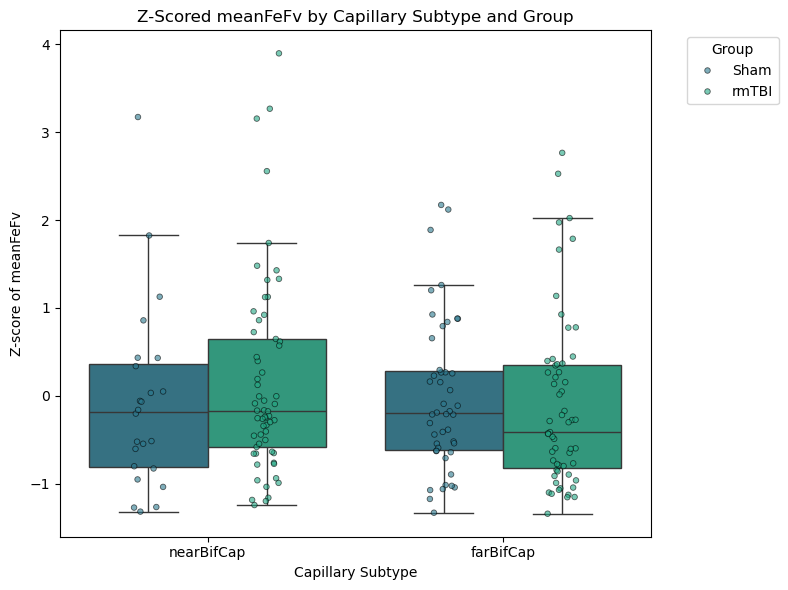

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure categories are ordered for plotting
final_df['group'] = pd.Categorical(final_df['group'], categories=['Sham', 'rmTBI'], ordered=True)
final_df['VesselType'] = pd.Categorical(final_df['VesselType'], categories=['nearBifCap', 'farBifCap'], ordered=True)

plt.figure(figsize=(8, 6))

viridis_palette = sns.color_palette('viridis', 4)[1:4]  # Select 3 contrasting colors

# Boxplot
sns.boxplot(
    data=final_df,
    x='VesselType',
    y='Z_meanFeFv',
    hue='group',
    hue_order=['Sham', 'rmTBI'],
    #palette=['royalblue', 'darkorange'],
    palette=viridis_palette,
    width=0.8,
    showfliers=False
)

# Overlay scatter points (ROI-level)
sns.stripplot(
    data=final_df,
    x='VesselType',
    y='Z_meanFeFv',
    hue='group',
    hue_order=['Sham', 'rmTBI'],
    dodge=True,
    jitter=0.1,
    marker='o',
    size=4,
    # palette=['royalblue', 'darkorange'],
    palette=viridis_palette,
    edgecolor='black',
    linewidth=0.6,
    alpha=0.6
)

# Fix legend to remove duplicates
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), title='Group', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Z-Scored meanFeFv by Capillary Subtype and Group")
plt.ylabel("Z-score of meanFeFv")
plt.xlabel("Capillary Subtype")

# plt.grid(axis='n')
plt.tight_layout()
plt.show()


In [52]:
# # 10. Plot
# plt.figure(figsize=(8, 6))
# sns.boxplot(
#     data=final_df,
#     x='VesselType',
#     y='Z_meanFeFv',
#     hue='Group',
#     order=['nearBifCap', 'farBifCap'],
#     hue_order=['Sham', 'rmTBI'],
#     palette=['royalblue', 'darkorange'],
#     notch=True,
#     showfliers=False
# )
# sns.stripplot(
#     data=final_df,
#     x='VesselType',
#     y='Z_meanFeFv',
#     hue='Group',
#     order=['nearBifCap', 'farBifCap'],
#     hue_order=['Sham', 'rmTBI'],
#     dodge=True,
#     jitter=0.25,
#     alpha=0.6,
#     marker='o',
#     size=4,
#     palette=['royalblue', 'darkorange'],
#     edgecolor='black',
#     linewidth=0.3
# )

# plt.title("Z-Scored meanFeFv by Capillary Subtype and Group")
# plt.ylabel("Z-score of meanFeFv")
# plt.xlabel("Capillary Subtype")
# plt.grid(axis='y')

# # Fix legend
# handles, labels = plt.gca().get_legend_handles_labels()
# by_label = dict(zip(labels, handles))
# plt.legend(by_label.values(), by_label.keys(), title='Group', bbox_to_anchor=(1.05, 1), loc='upper left')

# plt.tight_layout()
# plt.show()